# Report of findings Task 1

## 1. Introduction

### Scope
This is a brief report to present the main findings from the exercise on the Cardiovascular disease dataset from Kaggle. The objective was to find the best model to predict the presence of cardiovascular disease, as that is the natural choice.

### Theory
Binary classification, as in the case of predicting disease (1) or no disease (0), involves categorizing data points into one of two groups. This can be done using many different kinds of models, with many hyperparameters. Here, 3 models were chosen, and hyperparameter optimization was performed using GridSearch with 5-fold cross-validation.

#### Models
The models were chosen based on simplicity, familiarity and suitability for the context. They are KNN, Linear Regression (elastic net), and Random Forest. Here's what makes them tick:

**KNN (K-Nearest Neighbors)** classifies a new data point based on the majority class among its 'k' nearest neighbors. It calculates the distance from the new point to all other points, identifies the nearest 'k' points, and then votes for the most frequent label.

Distance in n-dimensional space is calculated as follows:

$$d(p, q) = \sqrt{\sum_{i=1}^{n} (q_i - p_i)^2}$$

**Linear Regression** predicts the probability of a given data point belonging to one of two classes by the side of a calculated boundary on which the point lies, using a linear combination of input features. Elastic Net regularization was used, to find the best balance between Lasso and Ridge (100% Ridge turned out to be best).

It has a sigmoid function, always producing a value between 0-1 in an S-curve. The probability \(P\) that a given observation is in class 1 can be written as:
  $$P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n)}}$$
  Here, $e$ is the base of the natural logarithm, $X_1, X_2, ..., X_n$ are the independent variables, $\beta_0$ is the intercept, and $\beta_1, \beta_2, ..., \beta_n$ are the coefficients of the model that need to be learned from the training data.

**Random Forest** is an ensemble method that constructs multiple decision trees during training, and outputs the class that is the most fruqently voted on class by all the trees in the forest. Its randomness comes from selecting random subsets of the features at each split in the training of the trees, which helps in reducing overfitting and improving model accuracy over individual decision trees.

Given a set of decision trees ${T_1, T_2, ..., T_n}$, the Random Forest classification $C(x)$ for an input $x$ could be represented by the mode (most frequent class) of the classes predicted by all the trees in the forest:
  $$C(x) = \text{mode} \{ T_1(x), T_2(x), ..., T_n(x)\}$$

### 2. Description of the dataset (EDA)
The dataset contains health information about 70,000 people, half of which have cardiovascular disease. The dataset initially had not been cleaned, and contained unreasonable values like negative bloodpressure. Cleaning has been done at a later stage in this report, but in this initial EDA, some charachteristics are:

- The average **age** is 53 years, with no-one below 29½ years and no-one above 65. Age is the most highly correlated factor to cardiovascular disease in this dataset.
- 75% have normal **cholesterol level**, 14% above normal, and 12% high. Cholesterol level is the second most correlated predictor, after age.
- Average **weight** 74 kg and overweight according to BMI (27). Weight is it the third most correlated feature.

In [6]:
# Import cardiovascular dataset from Kaggle
# https://www.kaggle.com/sulianova/cardiovascular-disease-dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/cardio_train.csv', delimiter=';')

### Correlation Heatmap

<Axes: >

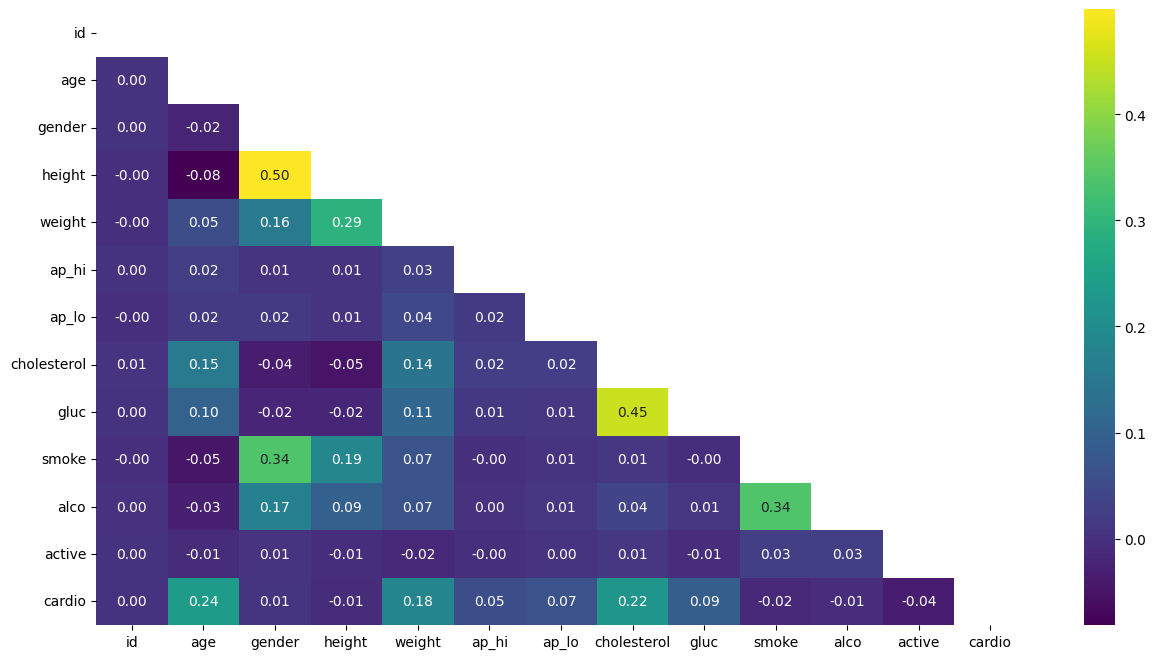

In [7]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), mask=mask, cmap='viridis', annot=True, fmt='.2f')

**Findings:** Age, weight, and cholesterol are the features most highly correlated to cardiovascular disease. Other notable correlations $( > 0.2 )$ are gender and weight to height, glucose to cholesterol, alcohol and gender to smoke.

### 2.1 Feature Engineering
#### 2.1.1 BMI
A BMI feature was added, according to the BMI formula: $\text{BMI} = \text{Weight}/\text{Height}^2 $
Samples with unlikely BMI values (outside of the range 10-70) were discarded. The range was set based on a histplot with its outlier distribution, and a search on the internet for what is considered a plausible BMI range.

New one hot encoded features were introduced for the different BMI categories, with these value counts:

| Category     | Count | BMI           |
|--------------|-------|---------------|
| Normal       | 25804 | 18.5 – 25.0|
| Overweight   | 25073 | 25.0 – 30.0 |
| Obesity I    | 12211 | 30.0 – 35.0 |
| Obesity II   |  4390 | 35.0 – 40.0 |
| Obesity III  |  1836 | > 40 |
| Underweight  |   644 | < 18.5  |

**Findings:** Subsequent correlation analysis surprisingly showed that the obesity level with the highest association to cardio is level 1, after which it drops from 0.1 through 0.09 to 0.06 for class III.

#### 2.1.2 Blood Pressure
The following blood pressure categories were created as per the requirements specification, with the addition of a Hypotension category that was previously erroneously classified as healthy. These were added using one hot encoding.


| Condition              | Systolic Blood Pressure (mm Hg)      | Diastolic Blood Pressure (mm Hg) | Number of Cases |
|------------------------|--------------------------------------|----------------------------------|-----------------|
| Hypotension            | < 90                                 | < 60                             | 14              |
| Healthy                | < 120                                | < 80                             | 9538            |
| Elevated               | 120 – 129                            | < 80                             | 3112            |
| Stage 1 Hypertension   | 130 – 139 or                         | 80 – 89                          | 39749           |
| Stage 2 Hypertension   | 140 – 180 or                         | ≥ 90                             | 16319           |
| Hypertension Crisis    | > 180                                | > 120                            | 10              |

Unrealistic samples were filtered out, based on likely organ failure and reported values in the literature.

**Findings:** Subsequent correlation analysis showed that while Stage 1 Hypertension is slightly negatively correlated (-0.11) to cardio, **Stage 2 is of a relatively strong kind** (0.34). The other blood pressure categories are basically not correlated at all (0.01). This is in stark contrast to ap_hi (0.43) and ap_lo (0.33), which might suggest that there is no extra value from the blood pressure features.

## 3. Models
### 3.1 Datasets
The models were trained using two copies of the original dataframe, one with the categorical features added, and the other with only BMI added, as per the requirements.
### 3.2 Models
3 models were chosen: 
- **KNN** is simple, versatile, and makes no assumptions about the underlying data, suitable for complex real world datasets.
- **Linear Regression** provides insights into the relationship between the independent variables and the outcome, and is computationally efficient.
- **Random Forest** can handle complex relationships, and is less prone to overfitting.

## 4. Results
#### Hyperparameter tuning
The hyperparameters for each model were tuned using 5-fold GridSearch Cross Validation.

##### Categorical dataset
Evaluation metrics (based on the number of True/False Positives and True/False Negatives, the calculation of which is outside the scope of this report):

| Model      | Precision 0 | Recall 0 | F1-score 0 | Precision 1 | Recall 1 | F1-score 1 | Accuracy |
|------------|-------------|----------|------------|-------------|----------|------------|----------|
| Random Forest     | **0.68**        | **0.78**     | **0.73**       | **0.74**        | **0.64**     | **0.68**       | **0.71**     |
| Logistic   | **0.68**        | **0.78**     | 0.72       | **0.74**        | 0.63     | **0.68**       | 0.70     |
| KNN        | **0.68**        | 0.77     | 0.72       | 0.73        | 0.63     | **0.68**       | 0.70     |


All in all, *Random Forest* was the best performing model for this dataset. The following best hyperparameters were found, out of the options to examine (options based on guessing reasonable values):

| Parameter                 | Best Model Value | GridSearch Options            |
|---------------------------|------------------|-------------------------------|
| `n_estimators`    | 100              | [100, 200, 300]               |
| `max_depth`       | 10               | [10, 20, 30]                  |
| `min_samples_split`| 10              | [2, 5, 10]                    |
| `min_samples_leaf` | 4               | [2, 4]                        |
| `bootstrap`       | True             | [True, False]                 |
| `max_features`    | 'log2'           | ["sqrt", "log2"]              |


##### BMI Dataset
Evaluation metrics for the BMI dataset, which overall was more successful than the Categorical:
| Model         | Precision 0 | Recall 0 | F1-score 0 | Precision 1 | Recall 1 | F1-score 1 | Accuracy |
|---------------|-------------|----------|------------|-------------|----------|------------|----------|
| Random Forest | **0.71**    | **0.79** | **0.75**   | **0.76**    | **0.68** | **0.72**   | **0.74** |
| Logistic      | 0.70        | **0.79** | 0.74       | **0.76**    | 0.66     | 0.71       | 0.73     |
| KNN           | **0.71**    | **0.79** | **0.75**   | **0.76**    | 0.67     | 0.71       | 0.73     |

When training the BMI dataset, the GridSearch Options were modified based on the best hyperparameters found during the previous GridSearch, both in order to explore boundary values and to cut training time.

The best hyperparameters for the BMI Random Forest Grid Search:
| Parameter                 | Best Model Value | GridSearch Options            |
|---------------------------|------------------|-------------------------------|
| `n_estimators`    | 50               | [50, 75, 100]                 |
| `max_depth`       | 10               | [5, 8, 10]                    |
| `min_samples_split`| 20              | [10, 15, 20]                  |
| `min_samples_leaf` | 4               | [4, 8]                        |
| `bootstrap`       | True             | [True]                        |
| `max_features`    | 'log2'           | ['log2']                      |

Based on the table above we see that *Random Forest* is the best performing model also for this dataset. This model also improves upon all metrics of the Random Forest model for the categorical dataset.

##### Summary
Based solely on scoring, the chosen dataset was **BMI** and the chosen model **Random Forest**. 

| Metric                | Categorical Random Forest | BMI Random Forest |
|-----------------------|------------------------|-----------------------|
| Accuracy              | 0.71                   | **0.74**              |
| Precision Class 0     | 0.68                   | **0.71**              |
| Precision Class 1     | 0.74                   | **0.76**              |
| Recall Class 0        | 0.78                   | **0.79**              |
| Recall Class 1        | 0.64                   | **0.68**              |
| F1-Score Class 0      | 0.73                   | **0.75**              |
| F1-Score Class 1      | 0.68                   | **0.72**              |
| Macro Avg F1-Score    | 0.71                   | **0.73**              |
| Weighted Avg F1-Score | 0.71                   | **0.73**              |

## 5. Discussion

Judging by the training score, adjusting the GridSearch Options after the first run seems to have paid off, but there is no way of knowing what the results would have been had that not been the case.

#### Limitations and suggestions
- **Computational limitations**. More hyperparameters and models could have been explored given more resources.
- **Boosting** and more advanced models such as *Light Gradient Boosting Machine* might perform better.
- More aggressive trimming of **outliers**, instead of using the principle of "what is likely to ever happen", might have increased model performance.
- Basing more of the work on **findings from the EDA**, such as just using the highly correlating Stage 2 Hypertension, rather than following the requirements, might have yielded better results.
- The findings are only **based on and valid for the dataset**, which seems to be designed to include 2/3 men and 50% with cardiovascular disease of both sexes.
- Random Forest is **not the most easily interpreted model**. Interpretability would be preferable in a clinical setting. Given the marginal scoring advantage, one could consider whether to use other more easily interpretable models depending on context and setting, especially considering the potential use cases.

#### Use 
Given the model's precision and recall, roughly 1 in 4 will be a false negative or positive. 
- With metrics in the range 0.68-0.79, the model cannot be relied upon to any greater extent when it comes to diagnostics, but it can **support decision making** in clinical settings.
- It could also be used as a **screening tool** to help identify individuals at higher risk, particularly in cases where the prediction probabilites are high.